In [1]:
%matplotlib inline

import os
import random
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

from tqdm import tqdm

import skimage.io
import skimage.segmentation
import skimage.morphology

import sys
__file__ = 'full_experiment.ipynb'
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

import utils.dirtools  # utils package should has __init__.py in it
import utils.augmentation
import utils.model_builder
import utils.data_provider
import utils.metrics
import utils.objectives
import utils.evaluation

import keras.backend
import keras.callbacks
import keras.layers
import keras.models
import keras.optimizers
import tensorflow as tf

from config import config_vars

Using TensorFlow backend.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [3]:
# build session running on GPU 1
configuration = tf.ConfigProto()
configuration.gpu_options.allow_growth = True
# configuration.gpu_options.visible_device_list = "0, 1"
session = tf.Session(config = configuration)

# apply session
keras.backend.set_session(session)

In [4]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [5]:
config_vars["root_directory"] = 'DATA/DNA_FISH/'
experiment_name = '05'

- experiment 03: train on FISH, 
- experiment 04: continue train on DNA_FISH  
- experiment 05: directly train on DNA_FISH

In [6]:
config_vars = utils.dirtools.setup_working_directories(config_vars)
config_vars = utils.dirtools.setup_experiment(config_vars, experiment_name)

In [7]:
config_vars

{'root_directory': 'DATA/DNA_FISH/',
 'max_training_images': 0,
 'create_split_files': False,
 'training_fraction': 0.5,
 'validation_fraction': 0.25,
 'transform_images_to_PNG': True,
 'pixel_depth': 8,
 'min_nucleus_size': 25,
 'boundary_size': 2,
 'augment_images': False,
 'elastic_points': 16,
 'elastic_distortion': 5,
 'elastic_augmentations': 10,
 'learning_rate': 0.0001,
 'epochs': 15,
 'steps_per_epoch': 500,
 'batch_size': 10,
 'val_batch_size': 10,
 'rescale_labels': True,
 'crop_size': 256,
 'cell_min_size': 16,
 'boundary_boost_factor': 1,
 'object_dilation': 3,
 'raw_images_dir': 'DATA/DNA_FISH/raw_images/',
 'raw_annotations_dir': 'DATA/DNA_FISH/raw_annotations/',
 'path_files_training': 'DATA/DNA_FISH/training.txt',
 'path_files_validation': 'DATA/DNA_FISH/validation.txt',
 'path_files_test': 'DATA/DNA_FISH/test.txt',
 'normalized_images_dir': 'DATA/DNA_FISH/norm_images/',
 'boundary_labels_dir': 'DATA/DNA_FISH/boundary_labels/',
 'experiment_dir': 'DATA/DNA_FISH/experim

### PREPROCESS

<a list of 100 Patch objects>

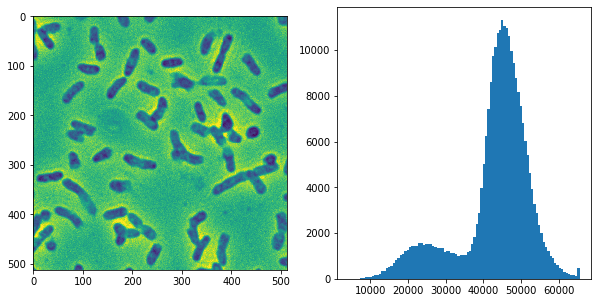

In [23]:
file_list = os.listdir(config_vars["raw_images_dir"])
img = skimage.io.imread(config_vars["raw_images_dir"] + file_list[-1])

figure, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(img)
ax[1].hist(img.flatten(), bins=100)[2]

In [6]:
os.makedirs(config_vars["normalized_images_dir"], exist_ok=True)
os.makedirs(config_vars["boundary_labels_dir"], exist_ok=True)

In [7]:
# normalize images

if config_vars["transform_images_to_PNG"]:
    filelist = sorted(os.listdir(config_vars["raw_images_dir"]))
    # run over all raw images
    for filename in tqdm(filelist):
        # load image and its annotation
        orig_img = skimage.io.imread(config_vars["raw_images_dir"] + filename)       
        # normalize to [0,1]
        percentile = 99.9
        high = np.percentile(orig_img, percentile)  # maximum for all image
        low = np.percentile(orig_img, 100-percentile)

        img = np.minimum(high, orig_img)
        img = np.maximum(low, img)

        # gives float64, thus cast to 8 bit later
        img = (img - low) / (high - low) 
        img = skimage.img_as_ubyte(img) 

        skimage.io.imsave(config_vars["normalized_images_dir"] + filename[:-3] + 'png', img)    
else:
    config_vars["normalized_images_dir"] = config_vars["raw_images_dir"]

  0%|          | 0/339 [00:00<?, ?it/s]/home/lanbowen23/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
100%|██████████| 339/339 [00:14<00:00, 23.60it/s]


In [9]:
# segmentation to boundary

filelist = sorted(os.listdir(config_vars["raw_annotations_dir"]))
filelist = [x for x in filelist if x.endswith('png')]
total_objects = 0

# run over all raw images
for filename in tqdm(filelist):
    # GET ANNOTATION
    annot = skimage.io.imread(config_vars["raw_annotations_dir"] + filename)
    
    # label the annotations nicely to prepare for future filtering operation
    annot = skimage.morphology.label(annot)
    total_objects += len(np.unique(annot)) - 1
    
    # filter small objects, e.g. micronulcei
    annot = skimage.morphology.remove_small_objects(annot, min_size=config_vars["min_nucleus_size"])
    # find boundaries
    boundaries = skimage.segmentation.find_boundaries(annot)
    # make the boundary wider
    for k in range(2, config_vars["boundary_size"], 2):
        boundaries = skimage.morphology.binary_dilation(boundaries)
        
    # 3-CHANNEL BINARY LABEL
    # prepare buffer for binary label
    label_binary = np.zeros((annot.shape + (3,)))  # cannot use dtype=np.uint8 here
    # write binary label
    label_binary[(annot == 0) & (boundaries == 0), 0] = 1  # bg
    label_binary[(annot != 0) & (boundaries == 0), 1] = 1  # cell
    label_binary[boundaries == 1, 2] = 1  # boundary
    # Convert an image to unsigned byte format, with values in [0, 255]
    label_binary = skimage.img_as_ubyte(label_binary)
    # save it - converts image to range from 0 to 255
    skimage.io.imsave(config_vars["boundary_labels_dir"] + filename, label_binary)
    
print("Total objects: ",total_objects)

100%|██████████| 339/339 [00:51<00:00,  8.44it/s]

Total objects:  22164


### TRAIN

#### Set Up Datasets

In [8]:
file_list = os.listdir(config_vars["normalized_images_dir"])
image_list = [x for x in file_list if x.endswith("png")]
len(image_list)

77

In [9]:
# set up train-valid split EVERY-TIME
def create_image_lists(dir_raw_images):
    file_list = os.listdir(dir_raw_images)
    image_list = [x for x in file_list if x.endswith("png")]
    image_list = sorted(image_list)

    image_list_train_aug = []
    image_list_test = []
    image_list_validation = image_list[63:]

    image_list_2 = image_list[:63]
    random.shuffle(image_list_2)
    image_list_train = image_list_2
    
#     image_list_train = []
#     image_list_validation = image_list  

    return image_list_train, image_list_test, image_list_validation, image_list_train_aug

In [10]:
[list_training, list_test, list_validation, list_training_aug] = create_image_lists(
    config_vars["normalized_images_dir"],
#         config_vars["training_fraction"],
#         config_vars["validation_fraction"]
)

utils.dirtools.write_path_files(config_vars["path_files_training"], list_training)
utils.dirtools.write_path_files(config_vars["path_files_test"], list_test)
utils.dirtools.write_path_files(config_vars["path_files_validation"], list_validation)

In [ ]:
# '''use matlab-labelled data to augment''' 
config_vars["path_files_training_aug"] = 'FISH/training_aug.txt'

# modify the write path method to add 'raw_masks/' ahead of the name
utils.dirtools.write_path_files2(config_vars["path_files_training_aug"], list_training_aug)

In [11]:
data_partitions = utils.dirtools.read_data_partitions(config_vars, load_augmented=False)

In [ ]:
# append aug filename to training split
with open(config_vars["path_files_training_aug"]) as f:
    data_partitions["training"] += f.read().splitlines()
    
data_partitions["training"]

##### data generator

In [12]:
# setup data-generator
train_gen = utils.data_provider.random_sample_generator(
    config_vars["normalized_images_dir"],
    config_vars["boundary_labels_dir"],
    data_partitions["training"],
    config_vars["batch_size"],
    config_vars["pixel_depth"],
    config_vars["crop_size"],
    config_vars["crop_size"],
    config_vars["rescale_labels"]
)

In [13]:
val_gen = utils.data_provider.single_data_from_images(
     config_vars["normalized_images_dir"],
     config_vars["boundary_labels_dir"],
     data_partitions["validation"],
     config_vars["val_batch_size"],
     config_vars["pixel_depth"],
     config_vars["crop_size"],
     config_vars["crop_size"],
     config_vars["rescale_labels"]
)

#### Model

In [14]:
# build model
model = utils.model_builder.get_model_3_class(config_vars["crop_size"], 
                                              config_vars["crop_size"], activation=None)
# model.summary()

#loss = "categorical_crossentropy"
loss = utils.objectives.weighted_crossentropy

metrics = [keras.metrics.categorical_accuracy, 
           utils.metrics.channel_recall(channel=0, name="background_recall"), 
           utils.metrics.channel_precision(channel=0, name="background_precision"),
           utils.metrics.channel_recall(channel=1, name="interior_recall"), 
           utils.metrics.channel_precision(channel=1, name="interior_precision"),
           utils.metrics.channel_recall(channel=2, name="boundary_recall"), 
           utils.metrics.channel_precision(channel=2, name="boundary_precision"),
          ]

optimizer = keras.optimizers.RMSprop(lr=config_vars["learning_rate"])

model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

In [15]:
# Callbacks
log_folder = 'logs/'
csv = keras.callbacks.CSVLogger(filename=config_vars["csv_log_file"])
tboard = keras.callbacks.TensorBoard(log_dir=log_folder + experiment_name, 
                                      histogram_freq=0, 
                                      batch_size=32, 
                                      write_graph=True, 
                                      write_grads=False, write_images=True,
                                      update_freq='epoch')
# add ModelCheckpoints
# monitor val-loss
weights_filename = log_folder + experiment_name + '/model-{epoch:02d}-{val_loss:.2f}.h5'
modelckp = keras.callbacks.ModelCheckpoint(weights_filename, verbose=1, period=1,
                                     save_best_only=True, save_weights_only=True)

# min_delta: threshold for measuring the new optimum,
#       to only focus on significant changes.
# cooldown: number of epochs to wait before resuming
#       normal operation after lr has been reduced.
reducelr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, 
                                             verbose=1, mode='min', min_lr=1e-7, 
                                             cooldown=10, min_delta=1e-4)
# min_lr could be smaller

callbacks = [csv, tboard, modelckp, reducelr]

In [36]:
# load weights
weight_h5_file = 'DATA/FISH/experiments/03/model.hdf5'
if os.path.isfile(weight_h5_file):
    try:
        model.load_weights(weight_h5_file)
    except:
        print('the model {} can not  be loaded'.format(weight_h5_file))
        pass

In [16]:
config_vars["epochs"] = 200

In [ ]:
# TRAIN
statistics = model.fit_generator(
    generator=train_gen,
    steps_per_epoch=config_vars["steps_per_epoch"],
    epochs=config_vars["epochs"],
    validation_data=val_gen,
    validation_steps=int(len(data_partitions["validation"])/config_vars["val_batch_size"]),
    callbacks=callbacks,
    verbose = 1
)
print('Done! :)')

# save one weight at the end of the training
model.save_weights(config_vars["model_file"])

Epoch 1/200
Training with 63 images.
500/500 [==============================] - 157s 315ms/step - loss: 0.6312 - categorical_accuracy: 0.8844 - background_recall: 0.9351 - background_precision: 0.9454 - interior_recall: 0.1946 - interior_precision: 0.3720 - boundary_recall: 0.3948 - boundary_precision: 0.1338 - val_loss: 0.2168 - val_categorical_accuracy: 0.9370 - val_background_recall: 0.9453 - val_background_precision: 0.9966 - val_interior_recall: 0.8066 - val_interior_precision: 0.6608 - val_boundary_recall: 0.9270 - val_boundary_precision: 0.2903

Epoch 00001: val_loss improved from inf to 0.21676, saving model to logs/05/model-01-0.22.h5
Epoch 2/200
500/500 [==============================] - 153s 307ms/step - loss: 0.5576 - categorical_accuracy: 0.9087 - background_recall: 0.9587 - background_precision: 0.9480 - interior_recall: 0.2416 - interior_precision: 0.5516 - boundary_recall: 0.4148 - boundary_precision: 0.1766 - val_loss: 0.2147 - val_categorical_accuracy: 0.9431 - val_ba

### PREDICT

In [20]:
config_vars['model_file'] = 'DATA/FISH/experiments/03/model.hdf5'

In [21]:
partition = "validation"
image_names = [os.path.join(config_vars["normalized_images_dir"], f) \
               for f in data_partitions[partition]]

imagebuffer = skimage.io.imread_collection(image_names)
images = imagebuffer.concatenate()

dim1 = images.shape[1]
dim2 = images.shape[2]
images = images.reshape((-1, dim1, dim2, 1))
# preprocess (assuming images are encoded as 8-bits in the preprocessing step)
images = images / 255

# build model and load weights
model = utils.model_builder.get_model_3_class(dim1, dim2)
model.load_weights(config_vars["model_file"])

# Normal prediction time
predictions = model.predict(images, batch_size=1)

In [22]:
def empty_dir(folder):
    print('empty directory: ', folder)
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            #elif os.path.isdir(file_path): shutil.rmtree(file_path)
        except Exception as e:
            print(e)

In [23]:
empty_dir(config_vars["probmap_out_dir"])
empty_dir(config_vars["labels_out_dir"])

empty directory:  DATA/IF_images/experiments/04/out/prob/
empty directory:  DATA/IF_images/experiments/04/out/segm/


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0000.png


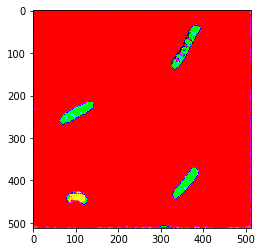

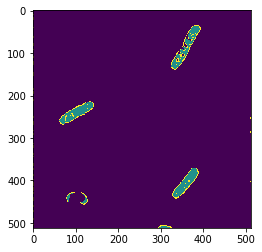

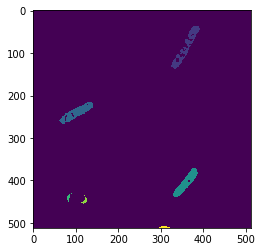

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0001.png


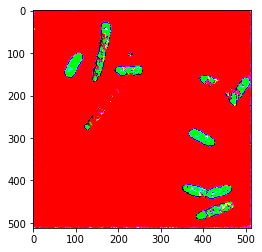

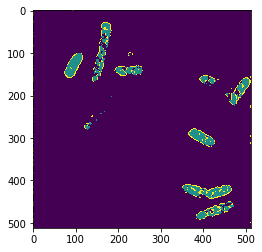

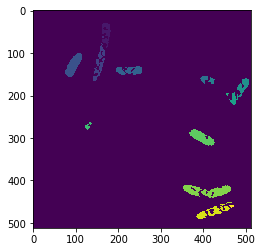

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0002.png


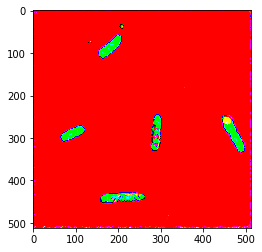

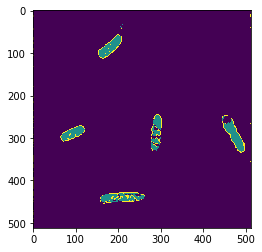

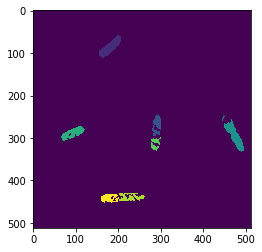

0003.png
0004.png
0005.png
0006.png
0007.png
0008.png
0009.png
0010.png
0011.png
0012.png
0013.png
0014.png
0015.png
0016.png
0017.png
0018.png
0019.png
0020.png
0021.png
0022.png
0023.png
0024.png
0025.png
0026.png
0027.png
0028.png
0029.png
0030.png
0031.png
0032.png
0033.png
0034.png
0035.png
0036.png
0037.png
0038.png
0039.png
0040.png
0041.png
0042.png
0043.png
0044.png
0045.png
0046.png
0047.png
0048.png
0049.png
0050.png
0051.png
0052.png
0053.png
0054.png
0055.png
0056.png
0057.png
0058.png
0059.png
0060.png
0061.png
0062.png
0063.png
0064.png
0065.png
0066.png
0067.png
0068.png
0069.png
0070.png
0071.png
0072.png
0073.png
0074.png
0075.png
0076.png
0077.png
0078.png
0079.png
0080.png
0081.png
0082.png
0083.png
0084.png
0085.png
0086.png
0087.png
0088.png
0089.png
0090.png
0091.png
0092.png
0093.png
0094.png
0095.png
0096.png
0097.png
0098.png
0099.png
0100.png
0101.png


In [24]:
# boundary to segmentation

for i in range(len(images)):
    filename = imagebuffer.files[i]
    filename = os.path.basename(filename)
    print(filename)
    
    probmap = predictions[i].squeeze()
#     skimage.io.imsave(config_vars["probmap_out_dir"] + filename, probmap)
    
    pred = utils.metrics.probmap_to_pred(probmap, config_vars["boundary_boost_factor"])
    label = utils.metrics.pred_to_label(pred, config_vars["cell_min_size"])
#     skimage.io.imsave(config_vars["labels_out_dir"] + filename, label)
    
    if (i < 3):
        plt.imshow(probmap)
        plt.show()
        plt.imshow(pred)
        plt.show()
        plt.imshow(label)
        plt.show() 


### Evaluation

In [ ]:
# Display prediction along with ground truth to visualize errors

def show(ground_truth, prediction, threshold=0.5, image_name="N"):
    # Compute Intersection over Union
    IOU = utils.evaluation.intersection_over_union(ground_truth, prediction)

    # Create diff map
    diff = np.zeros(ground_truth.shape + (3,))  # become 3 channels
    A = ground_truth.copy()
    B = prediction.copy()
    A[A > 0] = 1
    B[B > 0] = 1
    D = A - B
    
    # Object-level errors
    C = IOU.copy()
    C[C >= threshold] = 1
    C[C < threshold] = 0
    missed = np.where(np.sum(C, axis=1) == 0)[0]
    extra = np.where(np.sum(C, axis=0) == 0)[0]

    for m in missed:
        diff[ground_truth == m+1, 0] = 1
    for e in extra:
        diff[prediction == e+1, 2] = 1
    
    # Display figures
    fig, ax = plt.subplots(1, 4, figsize=(18,6))
    ax[0].imshow(ground_truth)
    ax[0].set_title("True objects: " + str(len(np.unique(ground_truth))))
    ax[1].imshow(diff)
    ax[1].set_title("Segmentation errors: " + str(len(missed)))
    ax[2].imshow(prediction)
    ax[2].set_title("Predicted objects:" + str(len(np.unique(prediction))))
    ax[3].imshow(IOU)
    ax[3].set_title(image_name)

In [ ]:
all_images = data_partitions[partition]  # validation

results = pd.DataFrame(columns=["Image", "Threshold", "F1", "Jaccard", "TP", "FP", "FN"])
false_negatives = pd.DataFrame(columns=["False_Negative", "Area"])
splits_merges = pd.DataFrame(columns=["Image_Name", "Merges", "Splits"])

for image_name in all_images:
    # Load ground truth data
    img_filename = os.path.join(config_vars["raw_annotations_dir"], image_name)
    ground_truth = skimage.io.imread(img_filename)
    if len(ground_truth.shape) == 3:
        ground_truth = ground_truth[:,:,0]
    
    # Transform to label matrix
    ground_truth = skimage.morphology.label(ground_truth)
    
    # Load predictions
    pred_filename = os.path.join(config_vars["labels_out_dir"], image_name)
    prediction = skimage.io.imread(pred_filename)
    
    # Apply object dilation
    if config_vars["object_dilation"] > 0:
        struct = skimage.morphology.square(config_vars["object_dilation"])
        prediction = skimage.morphology.dilation(prediction, struct)
    elif config_vars["object_dilation"] < 0:
        struct = skimage.morphology.square(-config_vars["object_dilation"])
        prediction = skimage.morphology.erosion(prediction, struct)
        
    # Relabel objects (cut margin of 30 pixels to make a fair comparison with DeepCell)
    ground_truth = skimage.segmentation.relabel_sequential(ground_truth)[0] #[30:-30,30:-30])[0]
    prediction = skimage.segmentation.relabel_sequential(prediction)[0] #[30:-30,30:-30])[0]
    
    # Compute evaluation metrics
    # Add result into pd dataframe one by one
    results = utils.evaluation.compute_af1_results(
        ground_truth, 
        prediction, 
        results, 
        image_name
    )
    
    false_negatives = utils.evaluation.get_false_negatives(
        ground_truth, 
        prediction, 
        false_negatives, 
        image_name
    )
    
    splits_merges = utils.evaluation.get_splits_and_merges(
        ground_truth, 
        prediction, 
        splits_merges, 
        image_name
    )
    
    # Display an example image
    if image_name == all_images[0]:
        show(ground_truth, prediction, image_name=image_name)

In [ ]:
average_performance = results.groupby("Threshold").mean().reset_index()
average_performance

In [ ]:
R = results.groupby("Image").mean().reset_index()
R.sort_values(by="F1", ascending=False)

In [ ]:
g = sb.jointplot(data=R[R["F1"] > 0.4], x="Jaccard", y="F1")

In [ ]:
# Plot accuracy results

sb.regplot(data=average_performance, x="Threshold", y="F1", order=3, ci=None)

In [ ]:
# Compute and print Average F1

average_F1_score = average_performance["F1"].mean()
jaccard_index = average_performance["Jaccard"].mean()
print("Average F1 score:", average_F1_score)
print("Jaccard index:", jaccard_index)

# Summarize False Negatives by area

false_negatives = false_negatives[false_negatives["False_Negative"] == 1]

false_negatives.groupby(
    pd.cut(
        false_negatives["Area"], 
        [0, 250, 625, 900, 10000], # Area intervals
        labels = ["Tiny nuclei","Small nuclei","Normal nuclei","Large nuclei"],
    )
)["False_Negative"].sum()

# Summarize splits and merges

print("Splits:", np.sum(splits_merges["Splits"]))
print("Merges:", np.sum(splits_merges["Merges"]))

# Report false positives

print("Extra objects (false postives): ", 
      results[results["Threshold"].round(3) == 0.7].sum()["FP"])

### PRINT Results

In [1]:
images_dirs = ['DATA/DNA_FISH/norm_images/',
              'DATA/IF_images/norm_images/',
              'DATA/Lineage_Tracking_ZY/norm_images/',
              'DATA/Lineage_Tracking_KZ/norm_images/']

labels_dirs = ['DATA/DNA_FISH/experiments/04/out/segm/',
              'DATA/IF_images/experiments/04/out/segm/',
              'DATA/Lineage_Tracking_ZY/experiments/04/out/segm/',
              'DATA/Lineage_Tracking_KZ/experiments/04/out/segm/']

In [ ]:
def difference(raw_label, pred_label):
    ground_truth = raw_label.copy()
    prediction = pred_label.copy()
    IOU = utils.evaluation.intersection_over_union(ground_truth, prediction)
    diff = np.zeros(ground_truth.shape + (3,))  # become 3 channels
    A = ground_truth.copy()
    B = prediction.copy()
    A[A > 0] = 1
    B[B > 0] = 1
    D = A - B
    #diff[D > 0,:2] = 1
    #diff[D < 0,1:] = 1
    
    # Object-level errors
    C = IOU.copy()
    threshold = 0.5  # if set to 0.8, more misses will appear, but 0.5 no miss
    C[C >= threshold] = 1
    C[C < threshold] = 0
    missed = np.where(np.sum(C, axis = 1) == 0)[0]  # for original cell, none predict cell match 
    extra = np.where(np.sum(C, axis = 0) == 0)[0]  # for predict cell, none original cell match

    for m in missed:
        diff[ground_truth == m + 1, 0] = 1
    for e in extra:
        diff[prediction == e + 1, 2] = 1
        
    return diff, str(len(missed)), str(len(extra))

In [2]:
def compare(img_name):
    original_images = []
    pred_labels = []
    for i in range(4):
        ori_img_filename = os.path.join(images_dirs[i], img_name)
        original_image = skimage.io.imread(ori_img_filename)
    
        pred_label_filename = os.path.join(labels_dirs[i], img_name)
        pred_label = skimage.io.imread(pred_label_filename)
        
        struct = skimage.morphology.square(3)
        pred_label = skimage.morphology.dilation(pred_label, struct)
        pred_label = skimage.segmentation.relabel_sequential(pred_label)[0] #[30:-30,30:-30])[0]
            
        # make graph easier to look
        inc = lambda x: x if x == 0 else x + 100
        inc = np.vectorize(inc)
        pred_label = inc(pred_label)
        
        original_images.append(original_image)
        pred_labels.append(pred_label)
        
    fig, ax = plt.subplots(2, 4, figsize=(20,10))
    fig.suptitle(img_name)
    ax[0][0].set_title("DNA_FISH")
    ax[0][0].imshow(original_images[0])
    ax[0][1].set_title("IF_images")
    ax[0][1].imshow(original_images[1])
    ax[0][2].set_title("Linear_Tracking_zy")
    ax[0][2].imshow(original_images[2])
    ax[0][3].set_title("Linear_Tracking_kz")
    ax[0][3].imshow(original_images[3])
    
#     ax[1][0].set_title("DNA_FISH")
    ax[1][0].imshow(pred_labels[0])
#     ax[1][1].set_title("IF_images")
    ax[1][1].imshow(pred_labels[1])
#     ax[1][2].set_title("Linear_Tracking_zy")
    ax[1][2].imshow(pred_labels[2])
#     ax[1][3].set_title("Linear_Tracking_kz")
    ax[1][3].imshow(pred_labels[3])


    # plt.figure(figsize=(6,6))
    # plt.imshow(original_image)  #, cmap="nipy_spectral")
    # plt.show()

In [7]:
for i in np.random.randint(74, size = 20):
    img = "{:04}".format(i) + ".png"
    compare(img)

FileNotFoundError: No such file: '/mnt/sde/lanbowen23/unet4nuclei/CELL/Lineage_Tracking_ZY_images/norm_images/0007.png'